<a href="https://colab.research.google.com/github/p4css/PSS/blob/master/world_air_route_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [Tutorial:Mapping the World’s Flight Paths with Python: Visualising the flight paths that link the World’s continents with Python](https://towardsdatascience.com/mapping-the-worlds-flight-paths-with-python-232b9f7271e5)
- [openflight](https://openflights.org/data.html)
- [openflight: github](https://github.com/jpatokal/openflights)
- raw data: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

# Loading airport data

In [3]:
import pandas as pd

airports = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", 
                       delimiter=',', names=['id', 'name', 'city', 'country', 'iata',
                                             'icao', 'lat', 'long', 'altitude', 'timezone',
                                             'dst', 'tz', 'type', 'source'])
airports

,id,name,city,country,iata,icao,lat,long,altitude,timezone,dst,tz,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


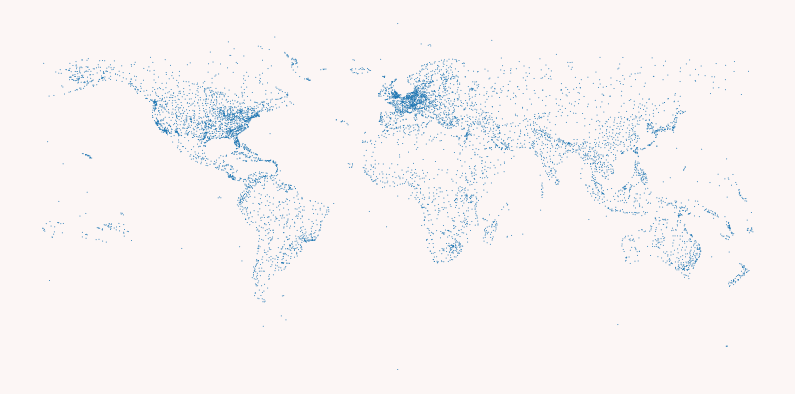

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)

ax.scatter(airports['long'], airports['lat'], s=1, alpha=1, edgecolors='none')
ax.axis('off')

plt.show()

# Loading route data
- data link from openflight: https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

In [5]:
routes = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat", 
                     delimiter=',', names=['airline', 'id', 'source_airport', 'source_airport_id',
                                           'destination_airport', 'destination_airport_id', 'codeshare',
                                           'stops', 'equitment'])
routes

,airline,id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equitment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334,ADL,3341,NaN,0,SF3
67659,ZM,19016,DME,4029,FRU,2912,NaN,0,734
67660,ZM,19016,FRU,2912,DME,4029,NaN,0,734
67661,ZM,19016,FRU,2912,OSS,2913,NaN,0,734


# Data manipulation: source -> destination
1. Create a duplicate airports DataFrame and label one as source and one as destination.
2. Merge the source DataFrame with the routes using the routes source iata code.
3. Merge the destination DataFrame with the routes using the routes destination iata code.
4. Use the latitude and longitude values of the source and destinations airports which are now merged into the routes DataFrame to create a LineString representing that route.

In [6]:
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]
destination_airports = source_airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

In [7]:
routes = routes[['source_airport', 'destination_airport']]
routes = pd.merge(routes, source_airports, left_on='source_airport', right_on='iata_source')
routes = pd.merge(routes, destination_airports, left_on='destination_airport', right_on='iata_destination')

print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


# using geopandas

In [8]:
# !pip install geopandas
import geopandas as gpd
from shapely.geometry import LineString

geometry = [LineString([[routes.iloc[i]['long_source'], routes.iloc[i]['lat_source']], [routes.iloc[i]['long_destination'], routes.iloc[i]['lat_destination']]]) for i in range(routes.shape[0])]
routes = gpd.GeoDataFrame(routes, geometry=geometry, crs='EPSG:4326')
print(routes)

      source_airport  ...                                           geometry
0                AER  ...  LINESTRING (39.95660 43.44990, 49.27870 55.60620)
1                ASF  ...  LINESTRING (48.00630 46.28330, 49.27870 55.60620)
2                CEK  ...  LINESTRING (61.50330 55.30580, 49.27870 55.60620)
3                DME  ...  LINESTRING (37.90630 55.40880, 49.27870 55.60620)
4                DME  ...  LINESTRING (37.90630 55.40880, 49.27870 55.60620)
...              ...  ...                                                ...
66929            ZKE  ...  LINESTRING (-81.67780 52.28250, -81.69690 52.2...
66930            YPO  ...  LINESTRING (-85.44330 54.98810, -82.43190 52.9...
66931            ZKE  ...  LINESTRING (-81.67780 52.28250, -82.43190 52.9...
66932            JCK  ...  LINESTRING (141.72301 -20.66830, 143.11501 -20...
66933            TRO  ...  LINESTRING (152.51401 -31.88860, 153.03000 -29...

[66934 rows x 13 columns]


# Data visualization

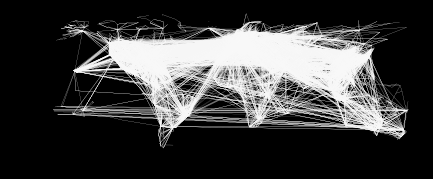

In [9]:
fig = plt.figure(facecolor='black')
ax = plt.axes()

fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('black')

routes.plot(ax=ax, color='white', linewidth=0.1)

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

plt.show()

## Projection

In [ ]:
!pip install cartopy
import cartopy.crs as ccrs

fig = plt.figure(facecolor='black')
ax = plt.axes(projection=ccrs.Robinson())
fig.set_size_inches(7, 3.5)
ax.patch.set_facecolor('black')

routes.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1)

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 8800000)

plt.show()